# Local Linear Embeddings (LLE)
### EECS 495: Optimization for Deep Learning
### Tushar Chandra

In this notebook, we will discuss the theory of local linear embedding (LLE), then demonstrate its application on a standard dataset.

## Theory

### Introduction

The first step in a data sciecne pipeline is often exploratory data analysis. A researcher or data scientist will often need to perform preliminary analysis on a new dataset prior to doing anything heavy with it, and this analysis often includes visualization. Most data, however, has more dimensions than can be visualized, and so dimensionality reduction is necessary. Though multiple techniques exist, we write about one unsupervised learning technique, local linear embedding.

At its core, local linear embedding computes low-dimensional, neighborhood-preserving representations of high-dimensional data. The original data usualy lies on a nonlinear manifold (a mathematical term for a surface that is smooth, but locally linear), and the data is mapped into a new coordinate system. The algorithm then reduces to a sparse eigenvalue problem, and does not run the risk of finding local minima, like some optimization problems.

### Algorithm

Here, we present the pseudocode for LLE. Optimizations exist to improve its performance, but we focus this project on the core algorithm itself.

1. Find the k nearest neighbors to each datapoint in the original space.

2. For every point:

    a. Compute the local covariance C of its nearest neighbors, and solve the linear system Cw = 1 for w.
    
    c. Set the reconstruction weights for the neighbors equal to the corresponding component of w, and the weights for all other points 0.
    
3. Compute the embedding coordinates by minimizing a quadratic form through finding its bottom nonzero eigenvectors.

### Discussion

We walk through each step of the algorithm in depth, and also discuss tie-ins to this course

***1. Finding neighbors in the original space.***

Recall that this algorithm preserves *local* relationships. It therefore makes sense that the first step is finding the closest neighbors to each point, as we later will reconstruct each point from those around it. Importantly, faraway points are discarded, so this is not guaranteed to preserve anything about the overall shape of the data; only linear relationships.

The effects of neighborhood size is subtle. Choosing $K > D$ suggests that the original data is low-dimensional, and in this case each point can be perfectly reconstructed as a linear combination of its neighbors; should this be the case, we add some regulariztaion later to break the degeneracy. The value of $K$ is not known a priori, and instead provides an opportunity to apply domain knowledge about the problem in question or tune the parameter by hand.

***2. Compute the local covariance of the neighbors, solve a linear system, and compute the reconstruction weights.***

More specifically, if $X$ is a $N x D$ matrix ($N$ observations in $D$ dimensions), then we create the matrix $Z$ as a $K x D$ matrix of the $K$ nearest neighbors. For every point $X_i$, we subtract it from each row in $Z$, then compute the local covariance as $(Z - X_i) \cdot (Z - X_i)^T$. (Note the abuse of notation to subtract a single row $X_i$ from each row in a matrix $Z$.)

It is sometimes the case that the local covariance matrix $C$ does not have full rank; in particular, this occurs when $K > D$. We *regularize* $C$ by adding a small constant times the identity matrix $I$ -- a standard approach is to set $C = 10^{-3} * trace(C) * I$.

Next, we solve the linear system $Cw = 1$ for a $K x 1$ vector of weights $w$. The regularization above was done so that this has a unique solution, and we implement this through standard linear algebra packages. The vector $w$ is normalized, and each component corresponds to the reconstruction weight of its corresponding neighbor.

We create a $KxK$ matrix $W$ to store all the weights, and each row $W_i$ corresponds to the reconstruction of the i-th point. We set the weights of $W_i$ that represent the neighbors of $X_i$ to the components of the vector $w$, and all others to 0.

The reconstruction weights have several useful symmetries -- they are invariant to rotations, rescalings, and translations of the data point and its neighbors. (Obviously, they are invariant to global transformations as well, but it is the invariance under local transformations that sits at the heart of the algorithm.) The reconstruction weights therefore characterize intrinsic geometric properties of each data point's neighborhood. 

***3. Create the embedding coordinates from the reconstruction matrix.***

The last step is remarkably simple, and speaks to the elegance of this algorithm. We define a cost function based on the reconstruction errors; if $Y$ is the $N \cdot d$ mapping (in $d$ dimensions with $d < D$, the original dimensionality), then the cost function takes the form $$\Phi(Y) = \sum_i |\vec{Y_i} - \sum_j W_{ij} \vec{Y_j}|^2$$

This cost function is familiar to us, and it has a unique global minimum; the embedding can be solved by solving a sparse eigenvalue problem. This problem reduces to finding the bottom eigenvectors of the related matrix $M = (I - W)^T (I - W)$. Its first eigenvector will always be the $1$ vector, so the next $d$ lowest will give us the desired embedding in low dimensional space.

This opitimization scheme has a remarkable simplicity; it is not dependent on initializations, learning rates, or error tolerances. It is not one that can accidentally find a local minimum. Rather, this problem is analytically solvable and widely applicable for a variety of data visualization purposes.

### References

The primary reference was the original paper developing this method. We also referred to various websites online throughout the research process.

[1] Roweis, S. T., & Saul, L. K. (2000). Nonlinear dimensionality reduction by locally linear embedding. science, 290(5500), 2323-2326.

[2] https://cs.nyu.edu/~roweis/lle/algorithm.html

[3] https://stats.stackexchange.com/questions/82037/explain-steps-of-lle-local-linear-embedding-algorithm

[4] http://scikit-learn.org/stable/modules/generated/sklearn.manifold.locally_linear_embedding.html

## Demonstration

Here, we will implement and demonstrate LLE on the standard "Swiss roll" dataset. We begin with the usual imports.

In [1]:
import matplotlib
import numpy as np
import scipy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, neighbors

%matplotlib inline

In [2]:
# Generate Swiss roll dataset
N = 3000
X, color = datasets.samples_generator.make_swiss_roll(n_samples = N, noise = 0.5)

We will first visualize this dataset, since it is inherently 3 dimensional. This will allow us to understand and verify the correctness of our results. We do a standard 3D plot, then a projection into 2 dimensions to see the connectivity and topology of the data.

**Importantly, this is usually not possible to do.** Indeed, the reason that techniques like local linear embedding exist is precisely *because* of the need for methods to visualize high-dimensional data.

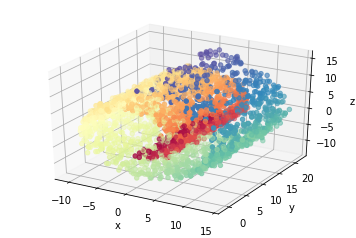

In [3]:
# Visualize dataset in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c = color, cmap = plt.cm.Spectral)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

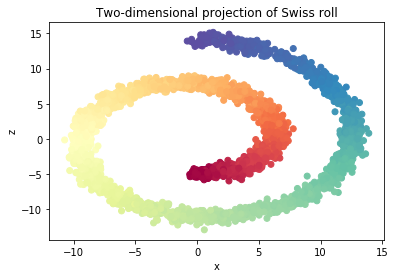

In [4]:
# Visualize dataset in 2D, projecting into the xz-plane
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[:, 0], X[:, 2], c = color, cmap = plt.cm.Spectral)

ax.set_title('Two-dimensional projection of Swiss roll')
ax.set_xlabel('x')
ax.set_ylabel('z');

We now implement the LLE algorithm. The first step is to compute the K nearest neighbors of each point in the dataset. The value of K is not previously known and must be tuned by hand; we use 24 here for demonstration purposes, but it is interesting to vary the value of K and watch the differences in the computed embeddings.

In [5]:
# Compute k nearest neighbors to each point
k = 24
nbors = neighbors.kneighbors_graph(X, n_neighbors = k)

Next, we compute the reconstruction weights. As described above, it is the case that $K > D$ (K is 24 and D is 3), so we must regularize the local covariance matrix when solving them. Since the neighbors graph is stored as a sparse matrix, we have to iterate over it in a slightly different way than usual.


In [6]:
# Compute reconstruction weights
W = np.zeros((N, N))
for i, nbor_row in enumerate(nbors):
    # Get the indices of the nonzero entries in each row of the
    # neighbors matrix (which is sparse). These are the nearest
    # neighbors to the point in question. dim(Z) = [K, D]
    inds = nbor_row.indices
    Z = X[inds] - X[i]
    
    # Local covariance. Regularize because our data is
    # low-dimensional (K > D). dim(C) = [K, K]
    C = Z @ Z.T
    C += np.eye(k) * np.trace(C) * 0.001    
    
    # Compute reconstruction weights
    w = scipy.linalg.solve(C, np.ones(k))
    W[i, inds] = w / sum(w)

The third step is to solve for the low dimensional embedding to minimize reconstruction error. This is done easily through linear algebra packages, leaving the core ideas of the algorithm clear.

In [7]:
# Create sparse, symmetric matrix
M = (np.eye(N) - W).T @ (np.eye(N) - W)
M = M.T

# Find bottom d+1 eigenvectors
d = 2
vals, vecs = scipy.linalg.eigh(M, eigvals = (0, d))

Finally, we visualize the result. Note that we discard the bottom eigenvector, so we set X2 equal to the second- and third-lowest eigenvectors intead.

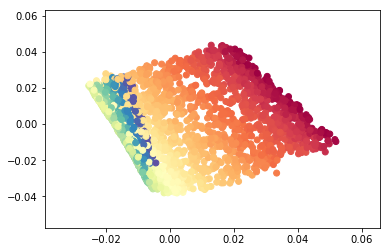

In [8]:
X2 = vecs[:, 1:]
plt.scatter(X2[:, 0], X2[:, 1], c = color, cmap = plt.cm.Spectral)

We see that LLE succeeded in "unraveling" the Swiss roll. It preserved local relationships as advertised; the color gradient from the original roll appears in this, and we see that the dataset's intrinsic topology is actually rather planar. This clearly demonstates the value of LLE - at no point did we suggest to the algorithm anything about the original dataset; rather, it learned it all itself.